<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/CondyleClassification/blob/main/condyleclassification8Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load modules/models from EVA course
!rm -rf Modules

!git clone https://github.com/DrVenkataRajeshKumar/CondyleClassification -q --quiet
!mv ./CondyleClassification/Modules ./Modules
!rm -rf CondyleClassification
#print("Loaded EVA4 Modules")
from Modules import *

# 2. Load Data & Set Data Loaders

In [3]:
# Downloading dataset and unziping into proper folder structure
!rm -rf final_images
!wget -q https://github.com/DrVenkataRajeshKumar/CondyleClassification/releases/download/data1/final.images.zip
!unzip -q final.images.zip


## 2.1 Calculate mean and standard deviation for the data

In [5]:
find_mean_standard_deviation("final.images/")

Sub-folders: ['Class 2- Bird beak', 'Class 4- crooked finger', 'Class 3-Diamond', 'Class 1- Oval']
Mean: [0.4625151  0.46880305 0.47351157]
Std: [0.19133939 0.19343658 0.19714876]
Processing completed in 0m 3s


## 2.2 Load images in to DataSet and also perform data transforms

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadDataset('final.images/', tstRatio = 0.3, batch_size = 20)

['Class 1- Oval', 'Class 2- Bird beak', 'Class 3-Diamond', 'Class 4- crooked finger']
835
207
201
65


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


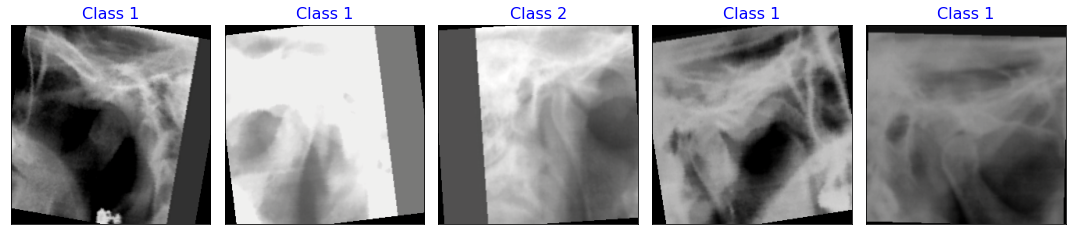

In [9]:
data.show_batch(save_as="sample.jpg")

# 4. Training Mobilenet Model - Only last layers
Modified last layer from 1000 classes to 4 and make only last layer trainable.
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [10]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Find hyper parameter lr value using LR Finder

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


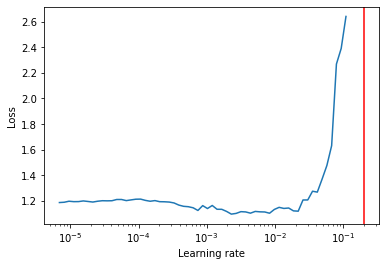

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.2) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.9, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

In [13]:
model_res, plotData = train_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWa

train Loss: 80.3409 Acc: 0.4449
val Loss: 100.8321 Acc: 0.6394

Epoch 1/24
----------
train Loss: 76.1563 Acc: 0.4776
val Loss: 117.0787 Acc: 0.1586

Epoch 2/24
----------
train Loss: 78.5677 Acc: 0.4635
val Loss: 38.2335 Acc: 0.1841

Epoch 3/24
----------
train Loss: 74.6344 Acc: 0.4591
val Loss: 42.3351 Acc: 0.3350

Epoch 4/24
----------
train Loss: 77.2573 Acc: 0.4537
val Loss: 59.6361 Acc: 0.6343

Epoch 5/24
----------
train Loss: 69.4940 Acc: 0.4656
val Loss: 62.7187 Acc: 0.6394

Epoch 6/24
----------
train Loss: 74.4549 Acc: 0.4700
val Loss: 69.0113 Acc: 0.1739

Epoch 7/24
----------
train Loss: 66.1747 Acc: 0.4733
val Loss: 65.8292 Acc: 0.6368

Epoch 8/24
----------
train Loss: 73.4557 Acc: 0.4591
val Loss: 54.4056 Acc: 0.6394

Epoch 9/24
----------
train Loss: 64.5571 Acc: 0.4624
val Loss: 86.6033 Acc: 0.6394

Epoch 10/24
----------
train Loss: 60.1312 Acc: 0.4820
val Loss: 41.1055 Acc: 0.6164

Epoch 11/24
----------
train Loss: 53.5753 Acc: 0.4962
val Loss: 64.7288 Acc: 0.6394

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


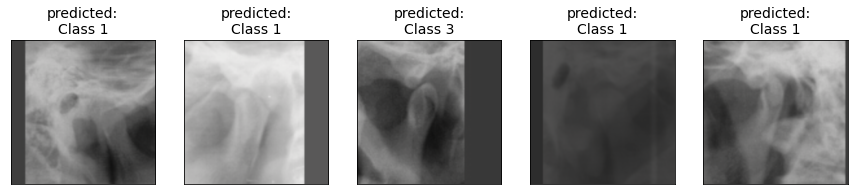

In [14]:
visualize_model(model_res, data, device,"visualize_1.jpg")

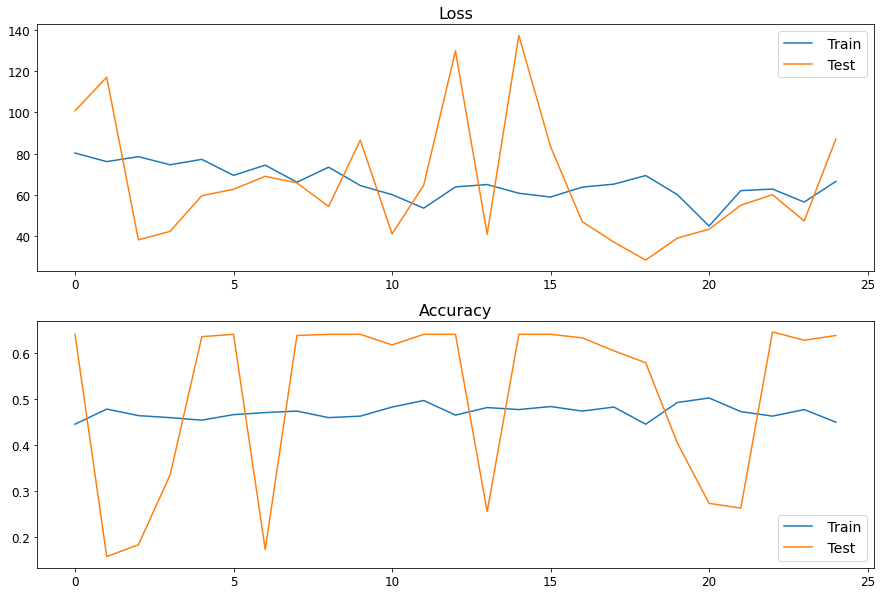

In [15]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

#6. Finetuning the Model by Training all layers
Load a trained model and unfreeze all the layers. Train again to improve the accuracy. 

In [16]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


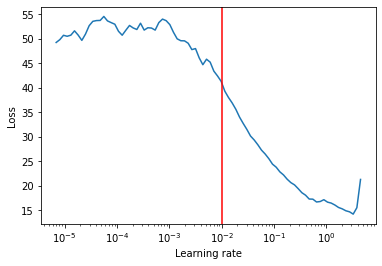

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [18]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9,nesterov=True, weight_decay=1e-4)

# One Cycle Policy
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs
                                          epochs=30,pct_start=0.2, div_factor=10, final_div_factor=100)

In [19]:
model_final, plotData = train_model(model_conv, data, device, criterion, optimizer_conv, scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 21.2199 Acc: 0.4864
val Loss: 88.1514 Acc: 0.5831

Epoch 1/29
----------
train Loss: 3.6399 Acc: 0.5365
val Loss: 8.6395 Acc: 0.6292

Epoch 2/29
----------
train Loss: 3.4708 Acc: 0.5442
val Loss: 16.4343 Acc: 0.6138

Epoch 3/29
----------
train Loss: 2.7543 Acc: 0.5878
val Loss: 1.7113 Acc: 0.6394

Epoch 4/29
----------
train Loss: 2.4430 Acc: 0.5921
val Loss: 1.0451 Acc: 0.6394

Epoch 5/29
----------
train Loss: 2.0259 Acc: 0.6085
val Loss: 1.4609 Acc: 0.6317

Epoch 6/29
----------
train Loss: 1.7511 Acc: 0.6150
val Loss: 1.0217 Acc: 0.6394

Epoch 7/29
----------
train Loss: 1.5978 Acc: 0.6150
val Loss: 1.0383 Acc: 0.6368

Epoch 8/29
----------
train Loss: 2.2978 Acc: 0.6074
val Loss: 1.0425 Acc: 0.6394

Epoch 9/29
----------
train Loss: 2.5918 Acc: 0.6096
val Loss: 1.6067 Acc: 0.6394

Epoch 10/29
----------
train Loss: 1.7324 Acc: 0.6183
val Loss: 1.0377 Acc: 0.6394

Epoch 11/29
----------
train Loss: 1.6362 Acc: 0.6074
val Loss: 1.6191 Acc: 0.6394

Epoch 12/29
---------

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


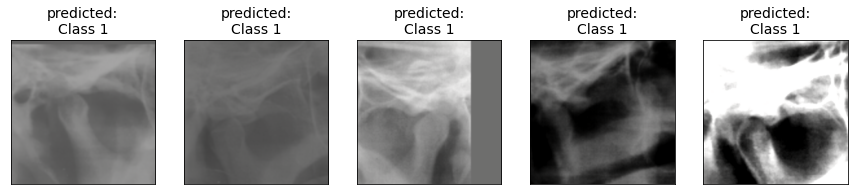

In [20]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.ioff()
plt.show()

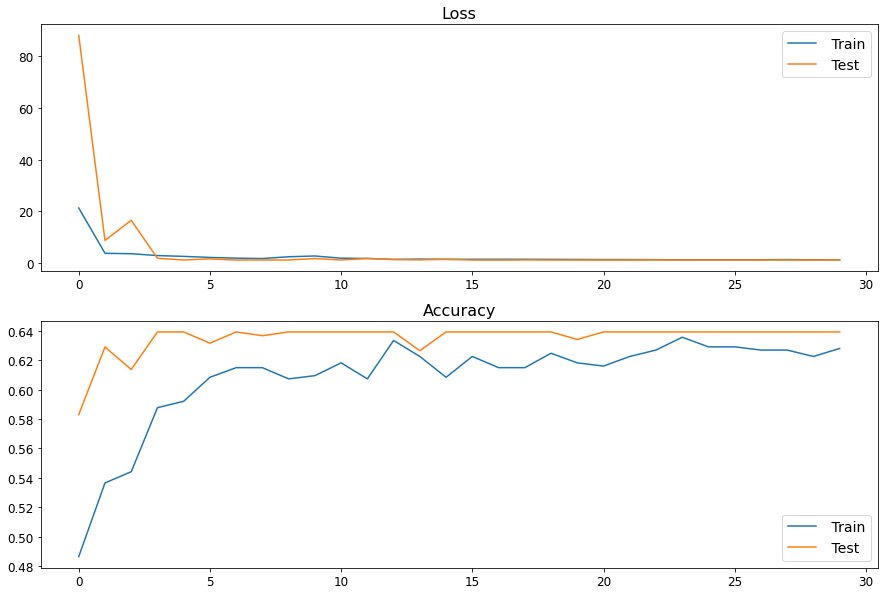

In [21]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

# 7. Plotting Misclassified images

Miss-Classified Images in Class 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


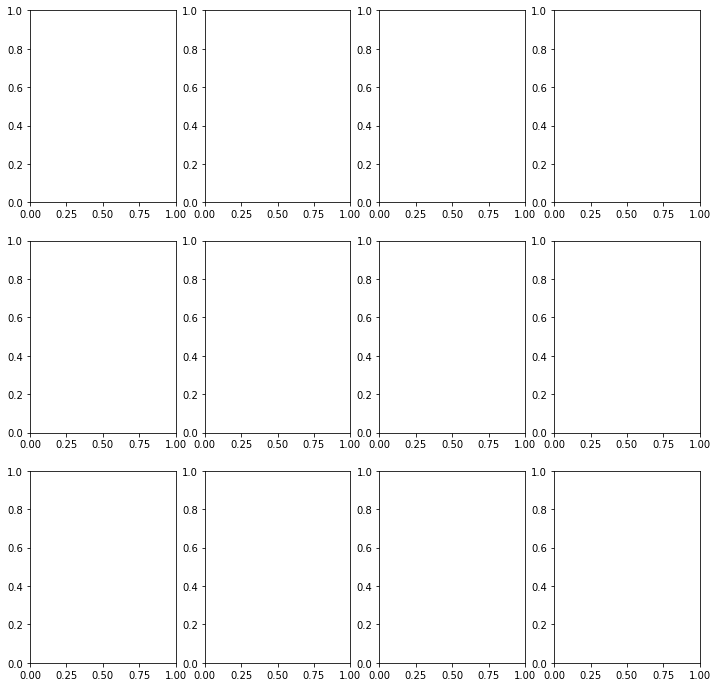

In [22]:
print("Miss-Classified Images in Class 1")
ShowMissclassifiedImages(model_final, data,0, device,save_as="MisclassifiedClass1.jpg")

Miss-Classified Images in Class 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


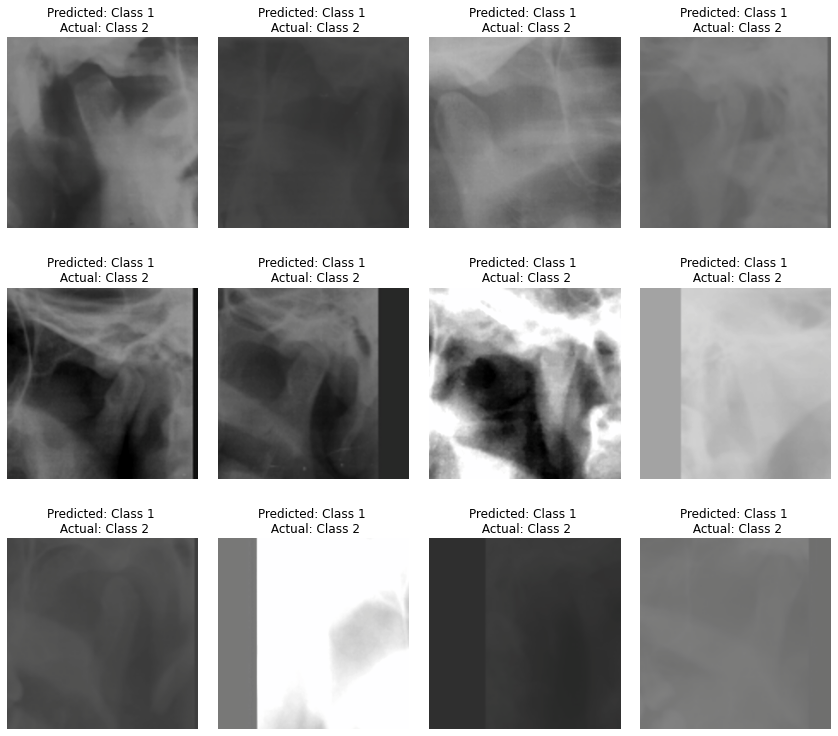

In [23]:
print("Miss-Classified Images in Class 1")
ShowMissclassifiedImages(model_final, data,1, device,save_as="MisclassifiedLargeQuadcopter.jpg")

In [ ]:
print("Miss-Classified Images in Small Quadcopters")
ShowMissclassifiedImages(model_final, data,2, device,save_as="MisclassifiedSmallQuadcopter.jpg")

In [ ]:
print("Miss-Classified Images in Winged Drones")
ShowMissclassifiedImages(model_final, data,3, device,save_as="MisclassifiedWingedDrones.jpg")

# 8. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v6.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v6.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v6.pt')